In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from skimage.io import imread
import cv2
import warnings
import os
import keras
warnings.filterwarnings(action='once')

Using TensorFlow backend.


In [2]:
# https://github.com/qubvel/segmentation_models
#https://pypi.org/project/keras-adabound/
#https://segmentation-models.readthedocs.io/en/latest/
!pip install git+https://github.com/qubvel/segmentation_models
!pip install keras-adabound
!pip install segmentation-models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-blmyvsth
    100% |████████████████████████████████| 81kB 5.3MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-3kce485m/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Stored in directory: /tmp/.cache/pip/wheels/26/fb/78/f6aa020cb8f098fecdf1e9043a9bb259c8414692d4225c6183
Successfully built keras-adabound
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Data Processing

In [3]:
train_path = '../input/train_v2/'
test_path = '../input/test_v2/'
data = pd.read_csv('../input/train_ship_segmentations_v2.csv')

In [4]:
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries

from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

train_image_dir = train_path
test_image_dir = test_path

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    if type(in_mask_list) == 'float':
        return all_masks
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Data Generator**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

(120186, 3)


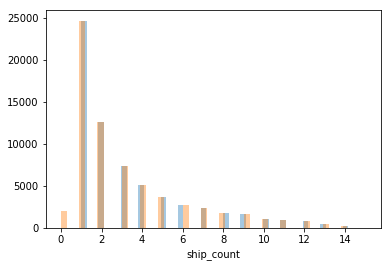

In [5]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
val = data[~msk]

train_no_ship = train[train["EncodedPixels"].isnull()]
train_with_ship = train[train["EncodedPixels"].notnull()]
train_with_ship['ship_count'] = train_with_ship.groupby('ImageId')['ImageId'].transform('count')
train_with_ship['ship_count'].fillna(0,inplace=True) 
train_no_ship['ship_count'] = 0
print(train_no_ship.shape)
sns.distplot(train_with_ship['ship_count'],kde=False);

down_sampled_no_ship = train_no_ship.sample(2000)
balanced_train = pd.concat([down_sampled_no_ship, train_with_ship])
#balanced_train = train_with_ship
sns.distplot(balanced_train['ship_count'],kde=False);

In [6]:
partition = {}
partition['train'] = balanced_train['ImageId'].values
partition['val'] = val['ImageId'].values
#labels = dict(zip(data['ImageId'].values, data['EncodedPixels'].values)) 

In [7]:
from skimage.transform import rotate
from skimage import exposure

In [8]:
def transform(image, rate=0.15):
    rnd = np.random.uniform(0, 1, 5)
    ## contrast
    if rnd[2] < rate:
        v_min, v_max = np.percentile(image, (0.2, 99.8))
        image= exposure.rescale_intensity(image, in_range=(v_min, v_max))
        
    ## horizontal flip
    if rnd[3] < rate:
        image= image[:, ::-1]
    
    ## vertical flip
    if rnd[4] < rate:
        image= image[::-1, :]
        
    ## rotation
    if rnd[0] < rate:
        deg = np.random.choice(range(6, 25))
        image= rotate(image, deg)
    
    return image
    

In [9]:
from keras.utils import Sequence

In [10]:
import gc 

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, data, batch_size=5, dim=(512, 512, 3), shuffle=True, resize_img = False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.resize = resize_img
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            path = os.path.join(train_path, ID)
            image = imread(path)
            encoded_pixels = self.data[self.data['ImageId']==ID]['EncodedPixels']
            mask = masks_as_image(encoded_pixels)
            if self.resize:
                resized_x = cv2.resize(image, (self.dim[0], self.dim[1]))
                X[i,] = transform(resized_x)/255.0
                resized_y = cv2.resize(mask, (self.dim[0], self.dim[1]))
                y[i] = np.reshape(resized_y, (self.dim[0], self.dim[1], 1))
            else:
                X[i,] = transform(image)/255.0
                y[i] = np.reshape(mask, (self.dim[0], self.dim[1], 1))
            gc.collect()
        gc.collect()
        return X, y

In [11]:
na = data[data['ImageId']=='00003e153.jpg']['EncodedPixels'].values[0]
type(na)

float

In [12]:
partition['train'].shape, partition['val'].shape
partition['reduced_train'] = np.random.choice(partition['train'], 8000)
partition['reduced_val'] = np.random.choice(partition['val'], 1000)

In [13]:
# Parameters

params = {'dim': (512, 512, 3),
          'batch_size': 4,
          'shuffle': True, 
         'resize_img':True}
"""


params = {'dim': (768, 512, 3),
          'batch_size': 1,
          'shuffle': True}
"""
# Generators

train_gen = DataGenerator(partition['reduced_train'], data, **params)
val_gen = DataGenerator(partition['reduced_val'], data, **params)

## Model

In [14]:
BATCH_SIZE = 24
MAX_TRAIN_STEPS = 10
steps_per_epoch = partition['reduced_train'].shape[0]//BATCH_SIZE
validation_steps = partition['reduced_val'].shape[0]//BATCH_SIZE

In [15]:
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras.callbacks import ModelCheckpoint ,ReduceLROnPlateau

def f2_micro(y_true, y_pred):
    agreement = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_true_positive = K.sum(K.round(K.clip(y_true, 0, 1)))
    total_pred_positive = K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = agreement / (total_true_positive + K.epsilon())
    precision = agreement / (total_pred_positive + K.epsilon())
    return (1+2**2)*((precision*recall)/(2**2*precision+recall+K.epsilon()))

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='fpn2_weights.hdf5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)

In [16]:
from segmentation_models import Unet, FPN
from segmentation_models.utils import set_trainable
from segmentation_models.losses import dice_loss
from keras_adabound import AdaBound

model = FPN()
model.compile(optimizer=AdaBound(lr=1e-3, final_lr=0.1), loss=dice_loss, metrics=[f2_micro])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)

hist = model.fit_generator(generator=train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=8,
                    pickle_safe=False,
                    callbacks=[checkpointer, reduce_lr],
                    verbose=1)

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


58892288/58889256 [==============================] - 2s 0us/step


/opt/conda/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<__main__...., validation_data=<__main__...., steps_per_epoch=333, validation_steps=41, epochs=8, callbacks=[<keras.ca..., verbose=1, use_multiprocessing=False)`


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/8
333/333 [==============================] - 370s 1s/step - loss: 0.9740 - f2_micro: 0.0180 - val_loss: 0.9931 - val_f2_micro: 0.0064

Epoch 00001: val_loss improved from inf to 0.99305, saving model to fpn2_weights.hdf5
Epoch 2/8
333/333 [==============================] - 345s 1s/step - loss: 0.9657 - f2_micro: 0.0161 - val_loss: 0.9890 - val_f2_micro: 0.0054

Epoch 00002: val_loss improved from 0.99305 to 0.98900, saving model to fpn2_weights.hdf5
Epoch 3/8
333/333 [==============================] - 352s 1s/step - loss: 0.9642 - f2_micro: 0.0161 - val_loss: 0.9915 - val_f2_micro: 0.0061

Epoch 00003: val_loss did not improve from 0.98900
Epoch 4/8
333/333 [==============================] - 350s 1s/step - loss: 0.9614 - f2_micro: 0.0169 - val_loss: 0.9931 - val_f2_micro: 0.0099

Epoch 00004: val_loss did not improve from 0.98900
Epoch 5/8
333/333 [==============================] - 350s 1s/step - loss

In [17]:
import json
# Get the dictionary containing each metric and the loss for each epoch
# Save it under the form of a json file
json.dump(hist.history, open("hist_dict.json", 'w'))

TypeError: Object of type 'float32' is not JSON serializable

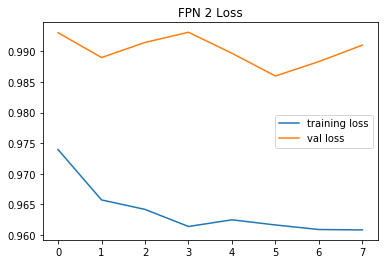

In [18]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"],label="training loss")
plt.plot(hist.history["val_loss"],label="val loss")
plt.title("FPN 2 Loss")
plt.legend()
plt.show()